# Propagação de epidemias em redes multicamada

Alunos:<br>
Caio Marcos Chaves Viana - 11208217<br>
Maria Teresa Raetano Cardoso - 10748604<br>
Paulo Matana da Rocha - 10892676

## Introdução

Esse trabalho visa comparar a propagaçã de epidemias em redes complexas, com uma ou mais camadas. Para isso desenvolvemos um pequeno fremework que realiza a conversão de redes geradas pela biblioteca Networkx em redes multicamada presentes na bilioteca pymnet. Também criamos funções capazes de simular os modelos de epidemia SIS, SIR e SIRS em redes com multiplas camadas.

## Modelagem em multiplas camadas

As simulações usadas no projeto seguem a ideia de uma maquina de estado que simula uma cadeia de Markov. O modelo realiza uma simulação com tempo discreto e atualização sincrona dos individuos, ou seja, todos os individuos são atualizado antes de realizar a atualização do tempo.
Em redes de uma camada temos que a simulação pode ser explicada pela imagem a seguir:

<img src="models_SL.png" width="400"/>

Nas redes multicamadas os vertices de mesmo indice em diferentes camadas indicam o mesmo individuo em redes diferentes. Dois o mesmo individuo pode possuim uma relação que conecta ele a ele mesmo em diferentes camadas, essa ligação é chamada de **inter-aresta** e pode possuim um valor que represente sua força. Pra modelar a propagação de epidemias em redes com mais de uma camada levando em consideração esses conceitos criamos um sistema onde o vértice pode infectar a si mesmo em outras camadas por meio de uma **inter-aresta**, além disso consideramos que a epidemia trata-se de um mesmo agente em todas as camadas, dessa forma quando um individuo se recupera em uma camada ele se recupera em todas. Podemos entender melhor o sistema olhando o diagrama a seguir, que representa o modelo SIR em uma rede de 3 camadas:

<img src="SIR_ML.png" width="500"/>

No esquema vemos a progressão de um unico individuo nas camadas **A**, **B** e **C**. Podemos ver que nesse modelo existe um valor $\lambda$ que representa a força da ligação intercamada desse individuo. Para os modelos SIS e SIRS temos criamos modelos analogos onde um infectado pode infectar a si mesmo em outras camadas.

In [8]:
import matplotlib.pyplot as plt
import numpy as np
arr = np.random.rand(30)
plt.plot(arr)
import pymnet as mn
import networkx as nx
from itertools import combinations

In [87]:
def convert_graph(M, layer, G): # funcao para converter redes Networkx em multicamadas
    if not(layer in M.get_layers()):
        print("Layer not found")
        return
    
    for i in G.nodes():
        M.add_node(i, layer)
        
    for i in G.edges():
        M[i[0], i[1], layer, layer] = 1
        
    return
        
def generate_inter_conections(M, p, v): # funcao para gerar aleatoriamente inter-conexoes
    comb = combinations(M.get_layers(), 2)
    for lrs in comb: 
        for i in M:
            if(np.random.rand() < p):
                M[i,i, lrs[0],lrs[1]] = v
    return

def change_inter_values(M, v): # funcao para alterar o valor das inter-conexoes 
    comb = combinations(M.get_layers(), 2)
    for lrs in comb: 
        for i in M:
            if(M[i,i, lrs[0],lrs[1]] != 0):
                M[i,i, lrs[0],lrs[1]] = v
    return

def find(v, i): #função que lista os individuos da classe i em todas as camadas
    arr = []
    for l in v:
        pos = 0
        for x in v[l]:
            if(x == i):
                arr.append((pos, l))
            pos = pos + 1
    return arr

def count(v, i): # função que conta de maneira unica cada individuo da classe i
    count = 0
    for j in range(len(v[next(iter(v))])):
        flag = 0
        for k in v:
            if(v[k][j] == i):
                flag = 1

        count += flag        

    return count

In [96]:
# Função que simula SIR em redes multicamada
def SIR(G, seed, beta=0.3, mu=1):    
    
    #definição das variáveis
    N = len(G) # numero de individuos na rede
    seed_nodes = seed
    t = 0 # contagem de tempo
    
    #inicia o vetor de estados
    vector_states = {}
    for i in G.get_layers():
        vector_states[i] = np.zeros(N) # vector that stores the states of the vertices]
    
    #inicia os individuos infectados no vetor de estados
    for i in seed_nodes:    
        vector_states[i[0]][i[1]] = 1 # 1 significa infectado
    
    #inicia as medições
    infected = list() # lista de individuos infectados para cada tempo
    vt = list() # lista de intervalos de tempo
    vI = list() # lista de fracao de infectados por intervalo de tempo
    vR = list() # lista de fracao de recuperados por intervalo de tempo
    vS = list() # lista de fracao de suscetiveis por intervalo de tempo
    
    # adiciona os valores para o tempo 0
    ninfected = count(vector_states,1)
    nrecovered = count(vector_states,2)
    vI.append(ninfected/N)
    vR.append(nrecovered/N)
    vS.append((len(G)-(ninfected+nrecovered))/N)
    vt.append(t)
    
    # realiza a simulação 
    while (ninfected > 0): # simula enquanto houver infectados ou o tempo for menor que max_it
        infected = find(vector_states,1) # lista infectados
        
         # tenta infectar visinhos e a si mesmo em outras camadas
        for i in infected:
            # itera pelos visinhos na camada
            for j in G[i[0],:,i[1],i[1]]:
                if np.random.rand() < beta:
                    if(vector_states[j[1]][j[0]] != 2): # verify if the node is not recovered
                        vector_states[j[1]][j[0]] = 1
                        
            # itera pelo individuo diferentes camadas
            for j in G[i[0], i[0], i[1], :]:
                if np.random.rand() < G[i[0], j[0], i[1], j[1]]:
                    vector_states[j[1]][j[0]] = 1
                    
        # tenta recuperar infectados                            
        for k in infected: 
            if np.random.rand() < mu:
                for lay in G.get_layers():
                    vector_states[lay][k[0]] = 2
        
        # atualiza estatisticas
        ninfected = count(vector_states,1)
        nrecovered = count(vector_states,2)
        vI.append(ninfected/N)
        vR.append(nrecovered/N)
        vS.append((len(G)-(ninfected+nrecovered))/N)
        t = t + 1
        vt.append(t)
        
    return vI, vS, vR, vt

In [97]:
# Função que simula SIRS em redes multicamada
def SIRS(G, seed, beta=0.3, mu=1, eta=0.3, max_it = 300):    
    
    #definição das variáveis
    N = len(G) # numero de individuos na rede
    seed_nodes = seed
    t = 0 # contagem de tempo
    
    #inicia o vetor de estados
    vector_states = {}
    for i in G.get_layers():
        vector_states[i] = np.zeros(N) # vector that stores the states of the vertices]
    
    #inicia os individuos infectados no vetor de estados
    for i in seed_nodes:    
        vector_states[i[0]][i[1]] = 1 # 1 significa infectado
    
    
    #inicia as medições
    infected = list() # lista de individuos infectados para cada tempo
    vt = list() # lista de intervalos de tempo
    vI = list() # lista de fracao de infectados por intervalo de tempo
    vR = list() # lista de fracao de recuperados por intervalo de tempo
    vS = list() # lista de fracao de suscetiveis por intervalo de tempo
    
    # adiciona os valores para o tempo 0
    ninfected = count(vector_states,1)
    nrecovered = count(vector_states,2)
    vI.append(ninfected/N)
    vR.append(nrecovered/N)
    vS.append((len(G)-(ninfected+nrecovered))/N)
    vt.append(t)
    
    # realiza a simulação 
    while (ninfected > 0 and t<max_it): # simula enquanto houver infectados ou o tempo for menor que max_it
        infected = find(vector_states,1) # lista infectados
        
         # tenta infectar visinhos e a si mesmo em outras camadas
        for i in infected:
            # itera pelos visinhos na camada
            for j in G[i[0],:,i[1],i[1]]:
                if np.random.rand() < beta:
                    if(vector_states[j[1]][j[0]] != 2): # verify if the node is not recovered
                        vector_states[j[1]][j[0]] = 1
                        
            # itera pelo individuo diferentes camadas
            for j in G[i[0], i[0], i[1], :]:
                if np.random.rand() < G[i[0], j[0], i[1], j[1]]:
                    vector_states[j[1]][j[0]] = 1
                    
        # tenta recuperar infectados                            
        for k in infected: 
            if np.random.rand() < mu:
                for lay in G.get_layers():
                    vector_states[lay][k[0]] = 2
        
        # tenta transformar infectados em suscetiveis 
        recovered = find(vector_states,2) 
        for k in recovered:
            if np.random.rand() < eta:
                for lay in G.get_layers():
                    vector_states[lay][k[0]] = 0
        
        # atualiza estatisticas
        ninfected = count(vector_states,1)
        nrecovered = count(vector_states,2)
        vI.append(ninfected/N)
        vR.append(nrecovered/N)
        vS.append((len(G)-(ninfected+nrecovered))/N)
        t = t + 1
        vt.append(t)
        
    return vI, vS, vR, vt

In [98]:
# function to simulate the SIR dynamics starting from a single seed node
def SIS(G, seed, beta=0.3, mu=1, max_it = 300):   
    
    #definição das variáveis
    N = len(G) # numero de individuos na rede
    seed_nodes = seed
    t = 0 # contagem de tempo
    
    #inicia o vetor de estados
    vector_states = {}
    for i in G.get_layers():
        vector_states[i] = np.zeros(N) # vector that stores the states of the vertices]
    
    #inicia os individuos infectados no vetor de estados
    for i in seed_nodes:    
        vector_states[i[0]][i[1]] = 1 # 1 significa infectado
    
    
    #inicia as medições
    infected = list() # lista de individuos infectados para cada tempo
    vt = list() # lista de intervalos de tempo
    vI = list() # lista de fracao de infectados por intervalo de tempo
    vS = list() # lista de fracao de suscetiveis por intervalo de tempo
    
    # adiciona os valores para o tempo 0
    ninfected = count(vector_states,1)
    vI.append(ninfected/N)
    vS.append((len(G)-(ninfected))/N)
    vt.append(t)
    
    # realiza a simulação 
    while (ninfected > 0 and t<max_it): # simula enquanto houver infectados ou o tempo for menor que max_it
        infected = find(vector_states,1) # lista infectados
        
         # tenta infectar visinhos e a si mesmo em outras camadas
        for i in infected:
            # itera pelos visinhos na camada
            for j in G[i[0],:,i[1],i[1]]:
                if np.random.rand() < beta:
                    if(vector_states[j[1]][j[0]] != 2): # verify if the node is not recovered
                        vector_states[j[1]][j[0]] = 1
                        
            # itera pelo individuo diferentes camadas
            for j in G[i[0], i[0], i[1], :]:
                if np.random.rand() < G[i[0], j[0], i[1], j[1]]:
                    vector_states[j[1]][j[0]] = 1
                    
        # tenta transformat infectados em suscetiveis
        for k in infected: 
            if np.random.rand() < mu:
                for lay in G.get_layers():
                    vector_states[lay][k[0]] = 0
        
        # atualiza estatisticas
        ninfected = count(vector_states,1)
        nrecovered = count(vector_states,2)
        vI.append(ninfected/N)
        vS.append((len(G)-(ninfected))/N)
        t = t + 1
        vt.append(t)

    return vI, vS, vt

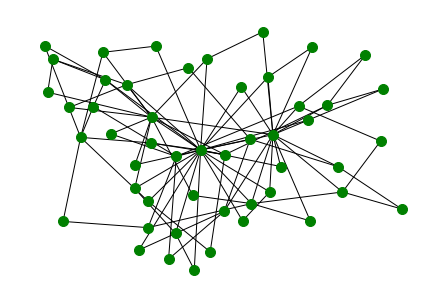

In [99]:
# definindo numero de vertices e grau médio
N = 50
av_degree = 4

# gerando rede pelo algoritmo de Barabasi-Albert
m = int(av_degree/2)
GBA = nx.barabasi_albert_graph(N, m)

# gerando rede pelo algoritmo de Erdos-Renyi
p = av_degree/(N-1)
GER = nx.gnp_random_graph(N, p, seed=None, directed=False)

nx.draw(GBA, node_size=100, node_color="green")

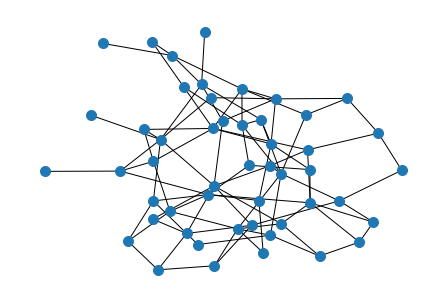

In [100]:
nx.draw(GER, node_size=100)

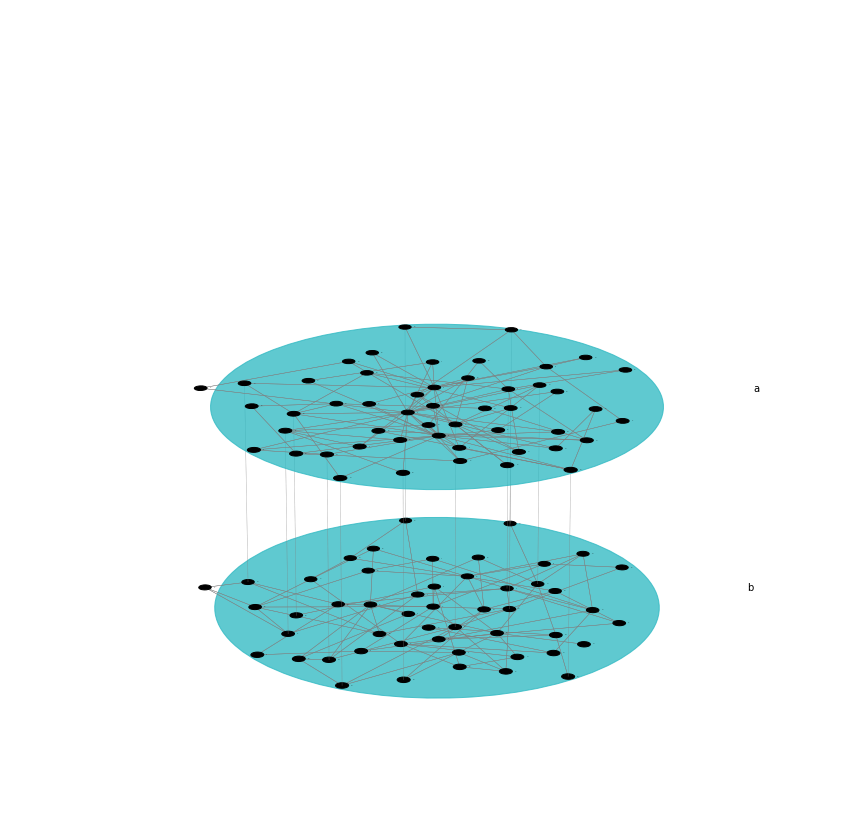

In [101]:
# Juntando as duas redes anteriores em uma rede multicamada
Mnet = mn.MultilayerNetwork(aspects=1)
Mnet.add_layer('a')
Mnet.add_layer('b')
convert_graph(Mnet, 'a', GBA)
convert_graph(Mnet, 'b', GER)

# gerando inter-conexoes
generate_inter_conections(Mnet, 0.3, 0.6)


fig = mn.draw(Mnet, layershape="circle", autoscale=True, figsize=(15,15), defaultNodeLabelSize=0, defaultEdgeWidth=0.4)

In [137]:
# definindo numero de vertices e grau médio
N = 100
av_degree_BA = 5
av_degree_ER = 15

# gerando rede pelo algoritmo de Barabasi-Albert
m = int(av_degree_BA/2)
GBA = nx.barabasi_albert_graph(N, m)

# gerando rede pelo algoritmo de Erdos-Renyi
p = av_degree_ER/(N-1)
GER = nx.gnp_random_graph(N, p, seed=None, directed=False)

# Juntando as duas redes anteriores em uma rede multicamada
M_net = mn.MultilayerNetwork(aspects=1)
M_net.add_layer('a')
M_net.add_layer('b')
convert_graph(M_net, 'a', GBA)
convert_graph(M_net, 'b', GER)

# gerando inter-conexoes
generate_inter_conections(Mnet, 0.2, 0.4)

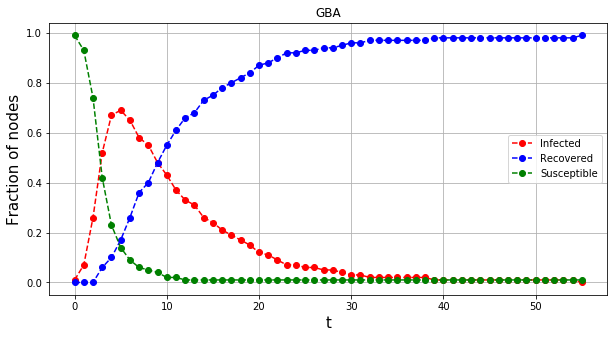

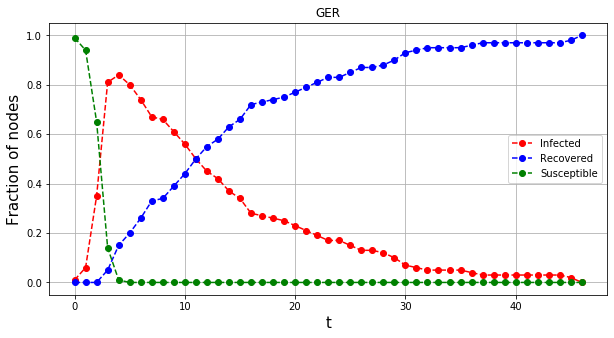

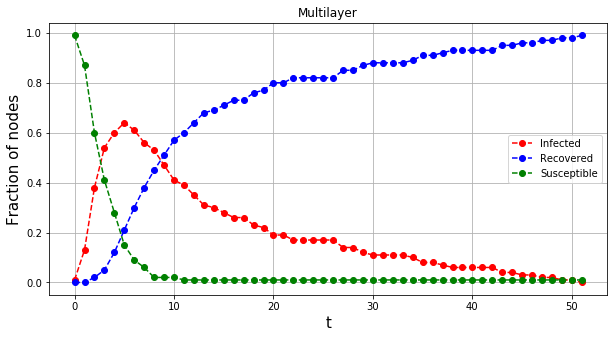

In [138]:
# Corverte as redes de uma camada pra o formato pymnet
M_GER = mn.MultilayerNetwork(aspects=1)
M_GBA = mn.MultilayerNetwork(aspects=1)
M_GER.add_layer('a')
M_GBA.add_layer('a')
convert_graph(M_GER, 'a', GER)
convert_graph(M_GBA, 'a', GBA)

beta = 0.3 # Probability of infection
mu = 0.1  # Probability of recovering
seed = [('a', 0)]
vI_BA, vS_BA, vR_BA, vt_BA = SIR(M_GBA, seed, beta, mu)
vI_ER, vS_ER, vR_ER, vt_ER = SIR(M_GER, seed, beta, mu)
vI_net, vS_net, vR_net, vt_net = SIR(M_net,seed, beta, mu)
    
plt.figure(figsize=(10,5))
plt.title("GBA")
plt.plot(vt_BA, vI_BA, 'ro--', label='Infected')
plt.plot(vt_BA, vR_BA, 'bo--', label='Recovered')
plt.plot(vt_BA, vS_BA, 'go--', label='Susceptible')
plt.xlabel("t", fontsize=15)
plt.ylabel("Fraction of nodes", fontsize=15)
plt.legend()
plt.grid(True)
plt.figure(figsize=(10,5))
plt.title("GER")
plt.plot(vt_ER, vI_ER, 'ro--', label='Infected')
plt.plot(vt_ER, vR_ER, 'bo--', label='Recovered')
plt.plot(vt_ER, vS_ER, 'go--', label='Susceptible')
plt.xlabel("t", fontsize=15)
plt.ylabel("Fraction of nodes", fontsize=15)
plt.legend()
plt.grid(True)
plt.figure(figsize=(10,5))
plt.title("Multilayer")
plt.plot(vt_net, vI_net, 'ro--', label='Infected')
plt.plot(vt_net, vR_net, 'bo--', label='Recovered')
plt.plot(vt_net, vS_net, 'go--', label='Susceptible')
plt.xlabel("t", fontsize=15)
plt.ylabel("Fraction of nodes", fontsize=15)
plt.legend()
plt.grid(True)
plt.show()

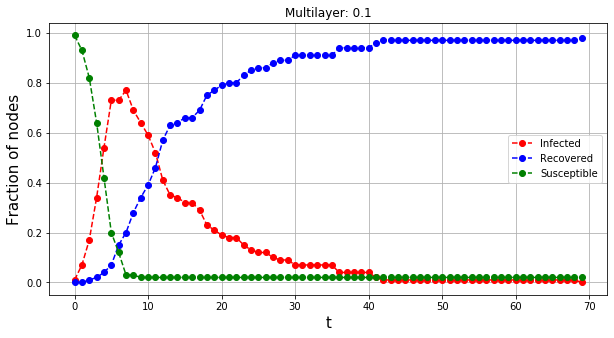

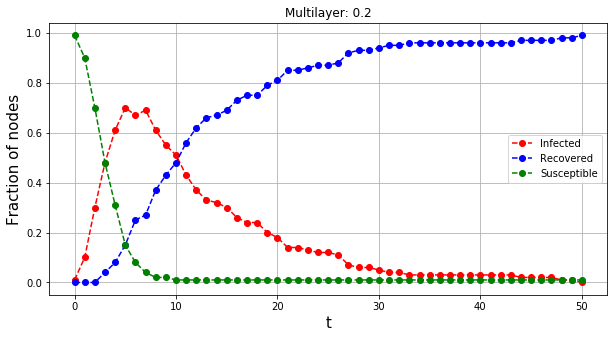

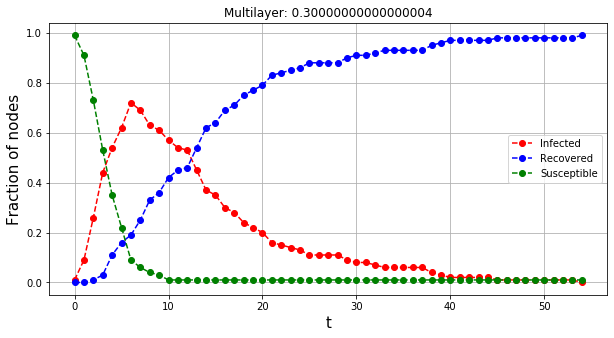

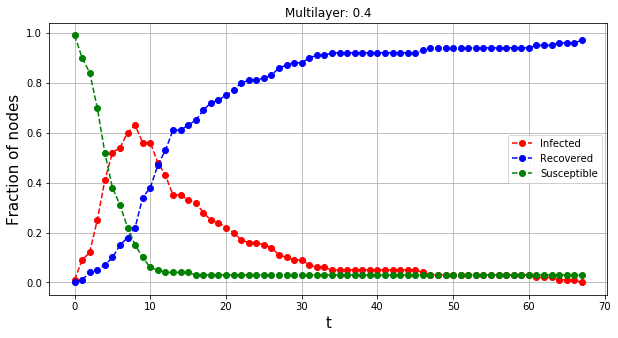

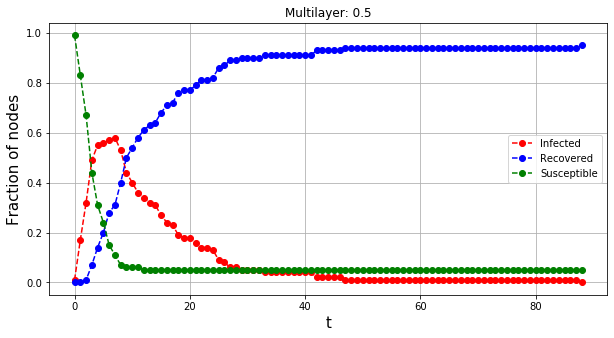

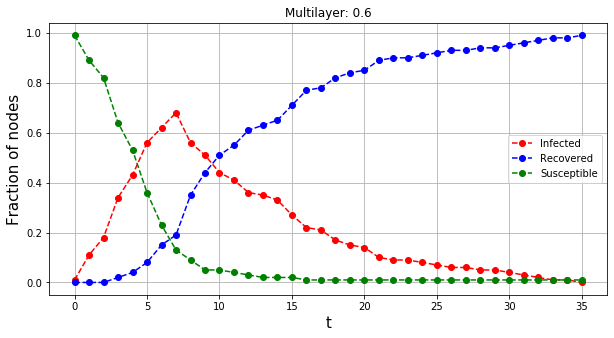

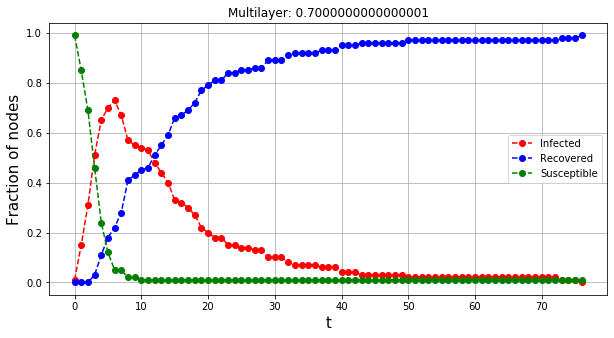

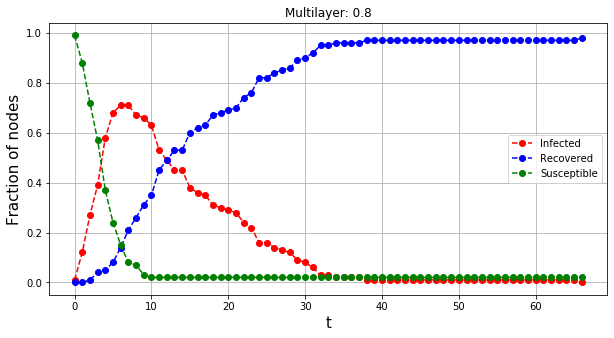

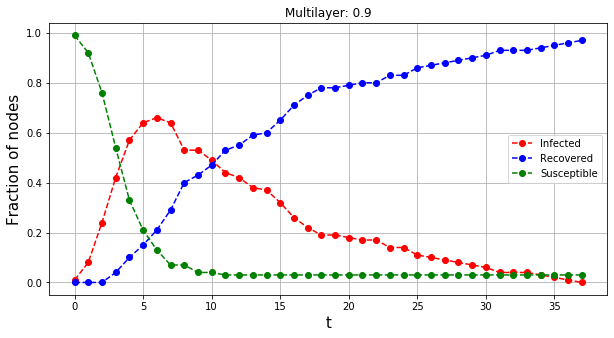

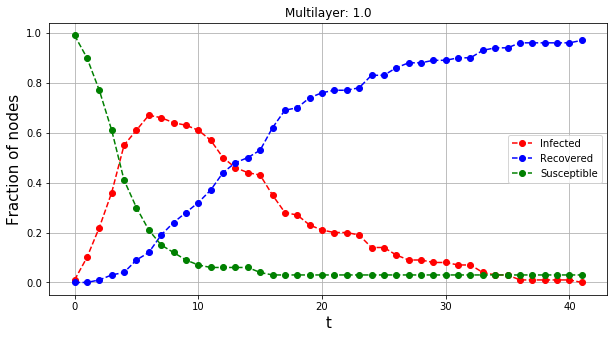

In [139]:
for i in np.arange(0.1, 1.1, 0.1):
    change_inter_values(Mnet, i)
    vI_net, vS_net, vR_net, vt_net = SIR(M_net,seed, beta, mu)
    plt.figure(figsize=(10,5))
    plt.title(f"Multilayer: {i}")
    plt.plot(vt_net, vI_net, 'ro--', label='Infected')
    plt.plot(vt_net, vR_net, 'bo--', label='Recovered')
    plt.plot(vt_net, vS_net, 'go--', label='Susceptible')
    plt.xlabel("t", fontsize=15)
    plt.ylabel("Fraction of nodes", fontsize=15)
    plt.legend()
    plt.grid(True)
    plt.show()